In [1]:
import os
import numpy as np
import matplotlib.pylab as plt

from physion.analysis.read_NWB import Data

filename = os.path.join(os.path.expanduser('~'), 'DATA', 'curated', '2022_03_01-14-26-08.nwb')

In [23]:
# same datafile with different Ca-Imaging preprocessing

LABELS = ['sliding percentile (5%%)\n neuropil corr. factor = 0.7',
          'minmax\n neuropil corr. factor = 0.7',
          'minmax\n no neuropil corr.']

# sliding percentile (SLOW) with neuropil correction, factor =0.7 
data1 = Data(filename)
data1.correctedFluo, data1.F0 = data1.build_dFoF(neuropil_correction_factor=0.7,
                                                 method_for_F0='sliding_percentile',
                                                 percentile=5.,
                                                 sliding_window=60.,
                                                 return_corrected_F_and_F0=True,
                                                 verbose=True)
data1.build_rawFluo()
data1.build_neuropil()
data1.io.close()
print('--------------------------------------------------------------')

# min max (FAST) with neuropil correction, factor =0.7 
data2 = Data(filename)
data2.correctedFluo, data2.F0 = data2.build_dFoF(neuropil_correction_factor=0.7,
                                                 method_for_F0='minmax',
                                                 sliding_window=60.,
                                                 return_corrected_F_and_F0=True,
                                                 verbose=True)
data2.build_rawFluo()
data2.build_neuropil()
data2.io.close()
print('--------------------------------------------------------------')

# min max (FAST) without neuropil correction
data3 = Data(filename)
data3.correctedFluo, data3.F0 = data3.build_dFoF(neuropil_correction_factor=0.,
                                                 method_for_F0='minmax',
                                                 sliding_window=60.,
                                                 return_corrected_F_and_F0=True,
                                                 verbose=True)
data3.build_rawFluo()
data3.build_neuropil()
data3.io.close()
print('--------------------------------------------------------------')




calculating dF/F with method "sliding_percentile" [...]

  ** all ROIs passed the positive F0 criterion ** 

-> dFoF calculus done !  (calculation took 14.5s)
--------------------------------------------------------------

calculating dF/F with method "minmax" [...]

  ** all ROIs passed the positive F0 criterion ** 

-> dFoF calculus done !  (calculation took 0.0s)
--------------------------------------------------------------

calculating dF/F with method "minmax" [...]

  ** all ROIs passed the positive F0 criterion ** 

-> dFoF calculus done !  (calculation took 0.0s)
--------------------------------------------------------------


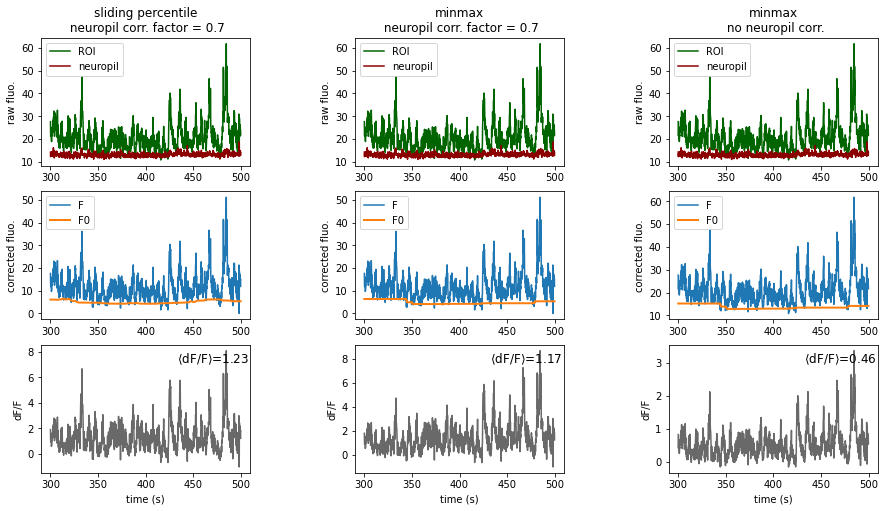

In [36]:

def plot_set_of_processed_data(set_of_data, set_of_label,
                     roiIndex = 1,
                     tzoom=[-np.inf, np.inf],
                     subsampling=5):
    
    t_cond = (data1.t_dFoF>tzoom[0]) & (data1.t_dFoF<tzoom[1])
    
    fig, AX = plt.subplots(3, len(set_of_data), figsize=(5*len(set_of_data), 8))
    plt.subplots_adjust(wspace=0.5)
    for d, data in enumerate(set_of_data):
        
        AX[0][d].set_title(set_of_label[d])
        # raw data
        AX[0][d].plot(data.t_dFoF[t_cond][::subsampling], data.rawFluo[roiIndex,t_cond][::subsampling], label='ROI', color='darkgreen')
        AX[0][d].plot(data.t_dFoF[t_cond][::subsampling], data.neuropil[roiIndex,t_cond][::subsampling], label='neuropil', color='darkred')
        AX[0][d].legend();AX[0][d].set_ylabel('raw fluo.')
        
        # corrected fluo.
        AX[1][d].plot(data.t_dFoF[t_cond][::subsampling], data.correctedFluo[roiIndex,t_cond][::subsampling], label='F')
        AX[1][d].plot(data.t_dFoF[t_cond][::subsampling], data.F0[roiIndex,t_cond][::subsampling], label='F0', lw=2)
        AX[1][d].legend();AX[1][d].set_ylabel('corrected fluo.')
        
        # dF/F
        AX[2][d].plot(data.t_dFoF[t_cond][::subsampling], data.dFoF[roiIndex,t_cond][::subsampling], color='dimgrey')
        AX[2][d].set_ylabel('dF/F')
        AX[2][d].set_xlabel('time (s)')
        
        AX[2][d].annotate(r'$\langle$dF/F$\rangle$=%.2f ' % np.mean(data.dFoF[roiIndex,:]), (1,.95),
                         xycoords='axes fraction', ha='right', va='top', fontsize=12)
        
plot_set_of_processed_data([data1, data2, data3], LABELS,
                            roiIndex=4,
                            tzoom=[300, 500])